In [43]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors
import matplotlib.colors
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from scipy.stats import linregress
import random
import geopandas as gpd

%config InlineBackend.figure_format = 'retina'

In [44]:
# parameters
focal_year = 2020

**Figure 1 -- ECI_software overview**

In [62]:
# data -- ECI_software
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[cdf["year"]==focal_year]
ubiquity_order = cdf[["language", "ubiquity"]].drop_duplicates().sort_values(by="ubiquity", ascending=False)["language"].to_list()

# data -- world map
cmap = gpd.read_file("../data/world-administrative-boundaries.geojson")
cmap = cmap[["iso3", "iso_3166_1_alpha_2_codes", "name", "geometry"]].rename(columns={"iso_3166_1_alpha_2_codes" : "iso2"})

In [63]:
def mcp_matrix(df, key_columns, heatmap, labels, fontsize, ax=None):
    table = df[key_columns]
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[0],
        columns=key_columns[1],
        aggfunc="sum",
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_title(labels[0], size=fontsize)
        ax.set_xlabel(labels[1], size=fontsize)
        ax.set_ylabel(labels[2], size=fontsize)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        
#mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Software", "Country", "Language"], fontsize=20)

In [64]:
# mcp trade / technology / research
trade_cdf = pd.read_csv("../outputs/trade_cdf_2020.csv", sep=";")
patent_cdf = pd.read_csv("../outputs/patent_cdf_2020.csv", sep=";")
research_cdf = pd.read_csv("../outputs/research_cdf_2020.csv", sep=";")

#mcp_matrix(trade_cdf, key_columns=["product", "iso2_code", "mcp"], heatmap=False, labels=["Trade", "Country", "Product category"], fontsize=20)
#mcp_matrix(patent_cdf, key_columns=["class", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "Country", "Patent class"], fontsize=20)
#mcp_matrix(research_cdf, key_columns=["category", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=20)

In [65]:
def map_complexity(geodf, c_column, fontsize, ax=None):
    if ax is None:
        ax = plt.gca()

    # create common colormap
    cvals  = [geodf[c_column].min(), geodf[c_column].max()]
    colors = ["darkblue","white"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    geodf.plot(column=c_column, cmap=cmap, edgecolor="None", ax=ax)

    # add boundaries
    geodf.boundary.plot(color="lightgrey", linewidth=0.125, ax=ax)

    # create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02, aspect=30, shrink=0.8, orientation="horizontal")
    cbar.set_label("ECI (software) ranking", rotation=0, labelpad=15, fontsize=fontsize)
    ax.axis('off')
    #cbar.set_ticks(bar_positions)
    #cbar.set_ticklabels(bar_labels)

    ax.set_axis_off()

In [66]:
cmap2 = pd.merge(
    cmap,
    cdf[["iso2_code", "eci"]].drop_duplicates(),
    left_on="iso2",
    right_on="iso2_code",
    how="left"
)
cmap2["eci_software_rank"] = cmap2["eci"].rank(ascending=False)

# map_complexity(cmap2, c_column="eci_software_rank", fontsize=20)

In [67]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

In [68]:
def eci_correlation_plot(df, key_variables, xlabel, ylabel, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.scatterplot(x=key_variables[0], y=key_variables[1], data=df, alpha=0.5, ax=ax)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[key_variables[0]], df[key_variables[1]])
    r_squared = r_value ** 2
    print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   ", key_variables[0], "  ", key_variables[1])
    ax.set_xlabel(xlabel, size=fontsize)
    ax.set_ylabel(ylabel, size=fontsize-2)
    ax.tick_params("x", labelsize=(fontsize-5))
    ax.tick_params("y", labelsize=(fontsize-5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0.015, tight=True)
    

#eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel=True, ylabel="ECI (trade)")

In [79]:
selected_countries = ["US", "RU", "CL"]

def lollipop_eci(df, selected_iso2, x_categories, y_values, c_code, fontsize, ylabel, xticks, title_text, ax=None):
    df = df[df["iso2_code"]==selected_iso2]
    df = df.set_index(x_categories).reindex(ubiquity_order).reset_index()

    if ax is None:
        ax = plt.gca()
    
    color_dict = {1:"darkblue", 0:"lightblue"}
    df["color_col"] = df["mcp"].map(color_dict)
    ax.scatter(df[x_categories], df[y_values], color=df["color_col"], s=15, zorder=4)
    ax.vlines(df[x_categories], ymin=0, ymax=df[y_values])
    if ylabel==True:
        ax.set_xlabel("Languages", size=fontsize)
    ax.set_ylabel("RCA", size=fontsize)
    if xticks==True:
        ax.tick_params("x", labelsize=(fontsize-10), rotation=90)
    else:
        ax.set_xticklabels("")
    ax.tick_params("y", labelsize=(fontsize))
    ax.margins(0.015, tight=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 5.65)
    ax.set_title(title_text, size=fontsize, loc="right")

#fig, ax = plt.subplots(1,1, figsize=(12,4))
#lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Chile", ax=ax[8])

R2 0.596 p-value 0.0     trade_eci_2020    software_eci_2020
R2 0.606 p-value 0.0     tech_eci_2020    software_eci_2020
R2 0.519 p-value 0.0     research_eci_2020    software_eci_2020


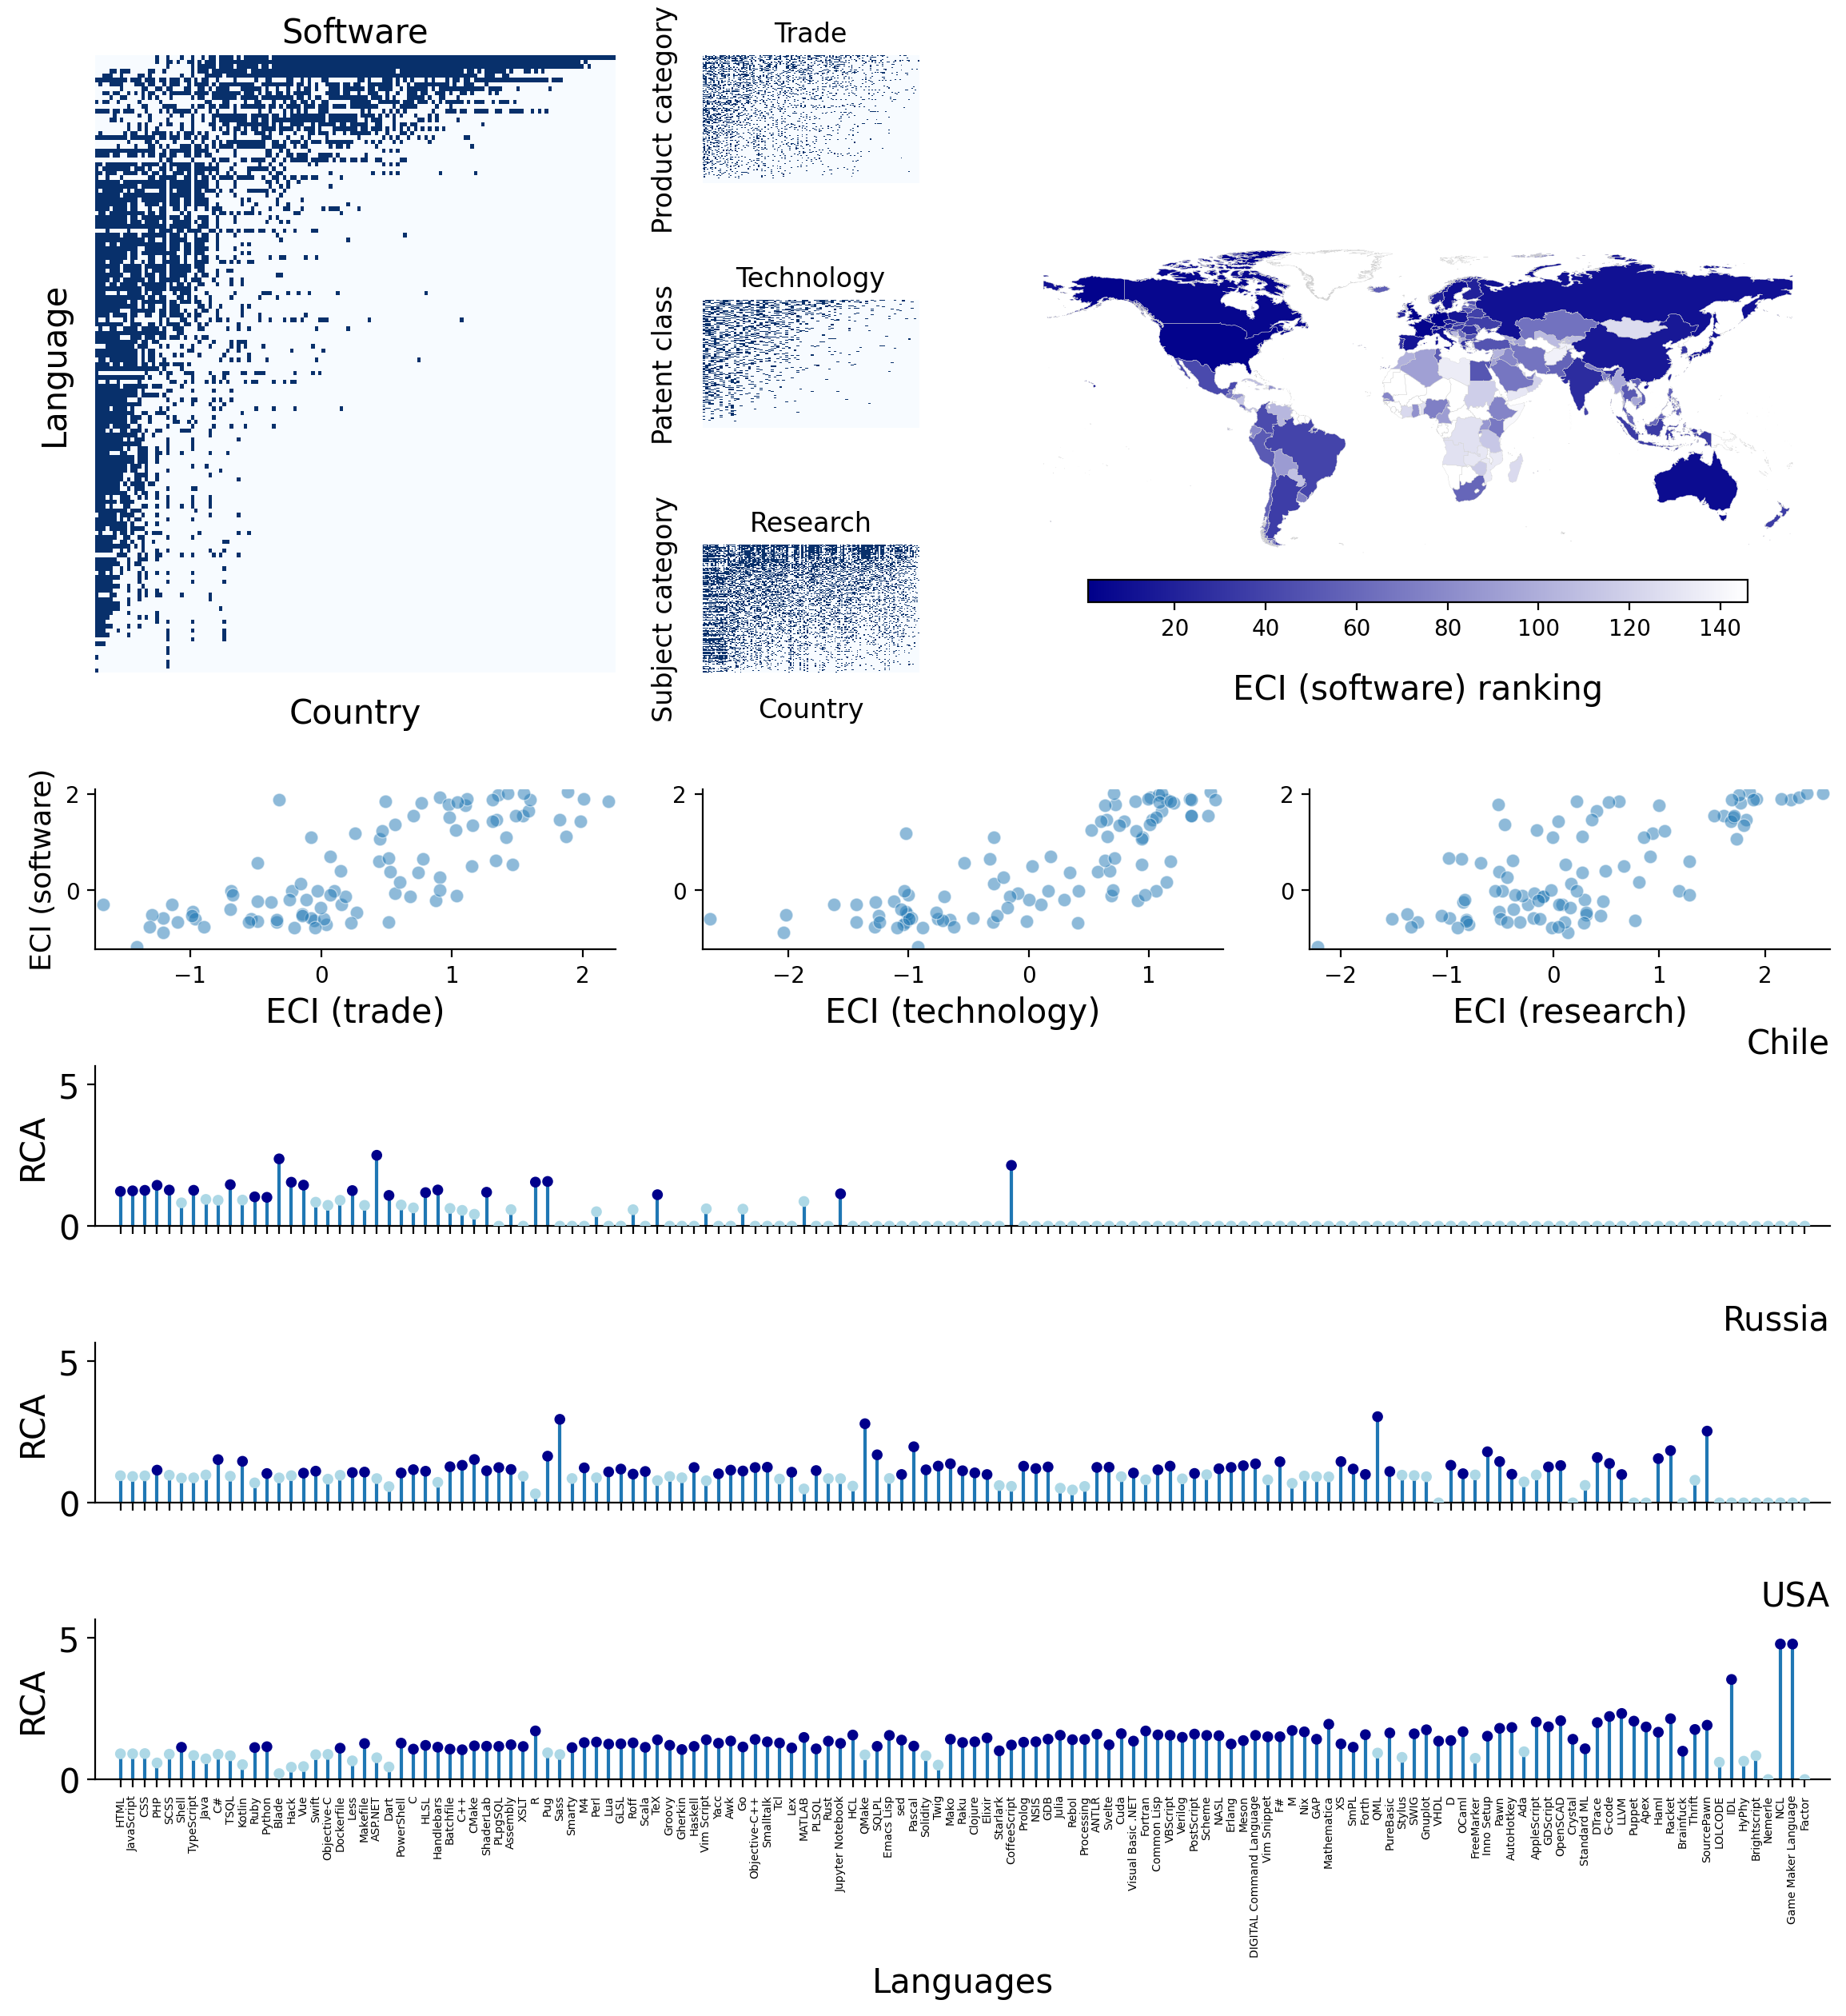

In [81]:
selected_countries = ["US", "RU", "CL"]
fontsize=15
fig = plt.figure(figsize=(14,14))

ax = [0]*11
gs = GridSpec(7,6, figure=fig, height_ratios=[0.8, 0.8, 0.8, 1, 1, 1, 1], width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.8, wspace=0.4)
ax[0] = fig.add_subplot(gs[0:3,0:2])
ax[1] = fig.add_subplot(gs[0,2])
ax[2] = fig.add_subplot(gs[1,2])
ax[3] = fig.add_subplot(gs[2,2])
ax[4] = fig.add_subplot(gs[0:3,3:6])

ax[5] = fig.add_subplot(gs[3,0:2])
ax[6] = fig.add_subplot(gs[3,2:4])
ax[7] = fig.add_subplot(gs[3,4:6])

ax[8] = fig.add_subplot(gs[4,0:])
ax[9] = fig.add_subplot(gs[5,0:])
ax[10] = fig.add_subplot(gs[6,0:])


# A -- M_software
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Software", "Country", "Language"], fontsize=fontsize, ax=ax[0])

# B
mcp_matrix(trade_cdf, key_columns=["product", "iso2_code", "mcp"], heatmap=True, labels=["Trade", "", "Product category"], fontsize=fontsize-3, ax=ax[1])

# C
mcp_matrix(patent_cdf, key_columns=["class", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "", "Patent class"], fontsize=fontsize-3, ax=ax[2])

# D
mcp_matrix(research_cdf, key_columns=["category", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=fontsize-3, ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])

# F
eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel="ECI (trade)", ylabel="ECI (software)", ax=ax[5])

# G
eci_correlation_plot(df2, key_variables=["tech_eci_2020", "software_eci_2020"], xlabel="ECI (technology)", ylabel="", ax=ax[6])

# H
eci_correlation_plot(df2, key_variables=["research_eci_2020", "software_eci_2020"], xlabel="ECI (research)", ylabel="", ax=ax[7])

# I -- example country 1
lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Chile", ax=ax[8])

# J -- example country 2
lollipop_eci(cdf, selected_iso2=selected_countries[1], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Russia", ax=ax[9])

# K -- example country 3
lollipop_eci(cdf, selected_iso2=selected_countries[0], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=True, xticks=True, title_text="USA", ax=ax[10])

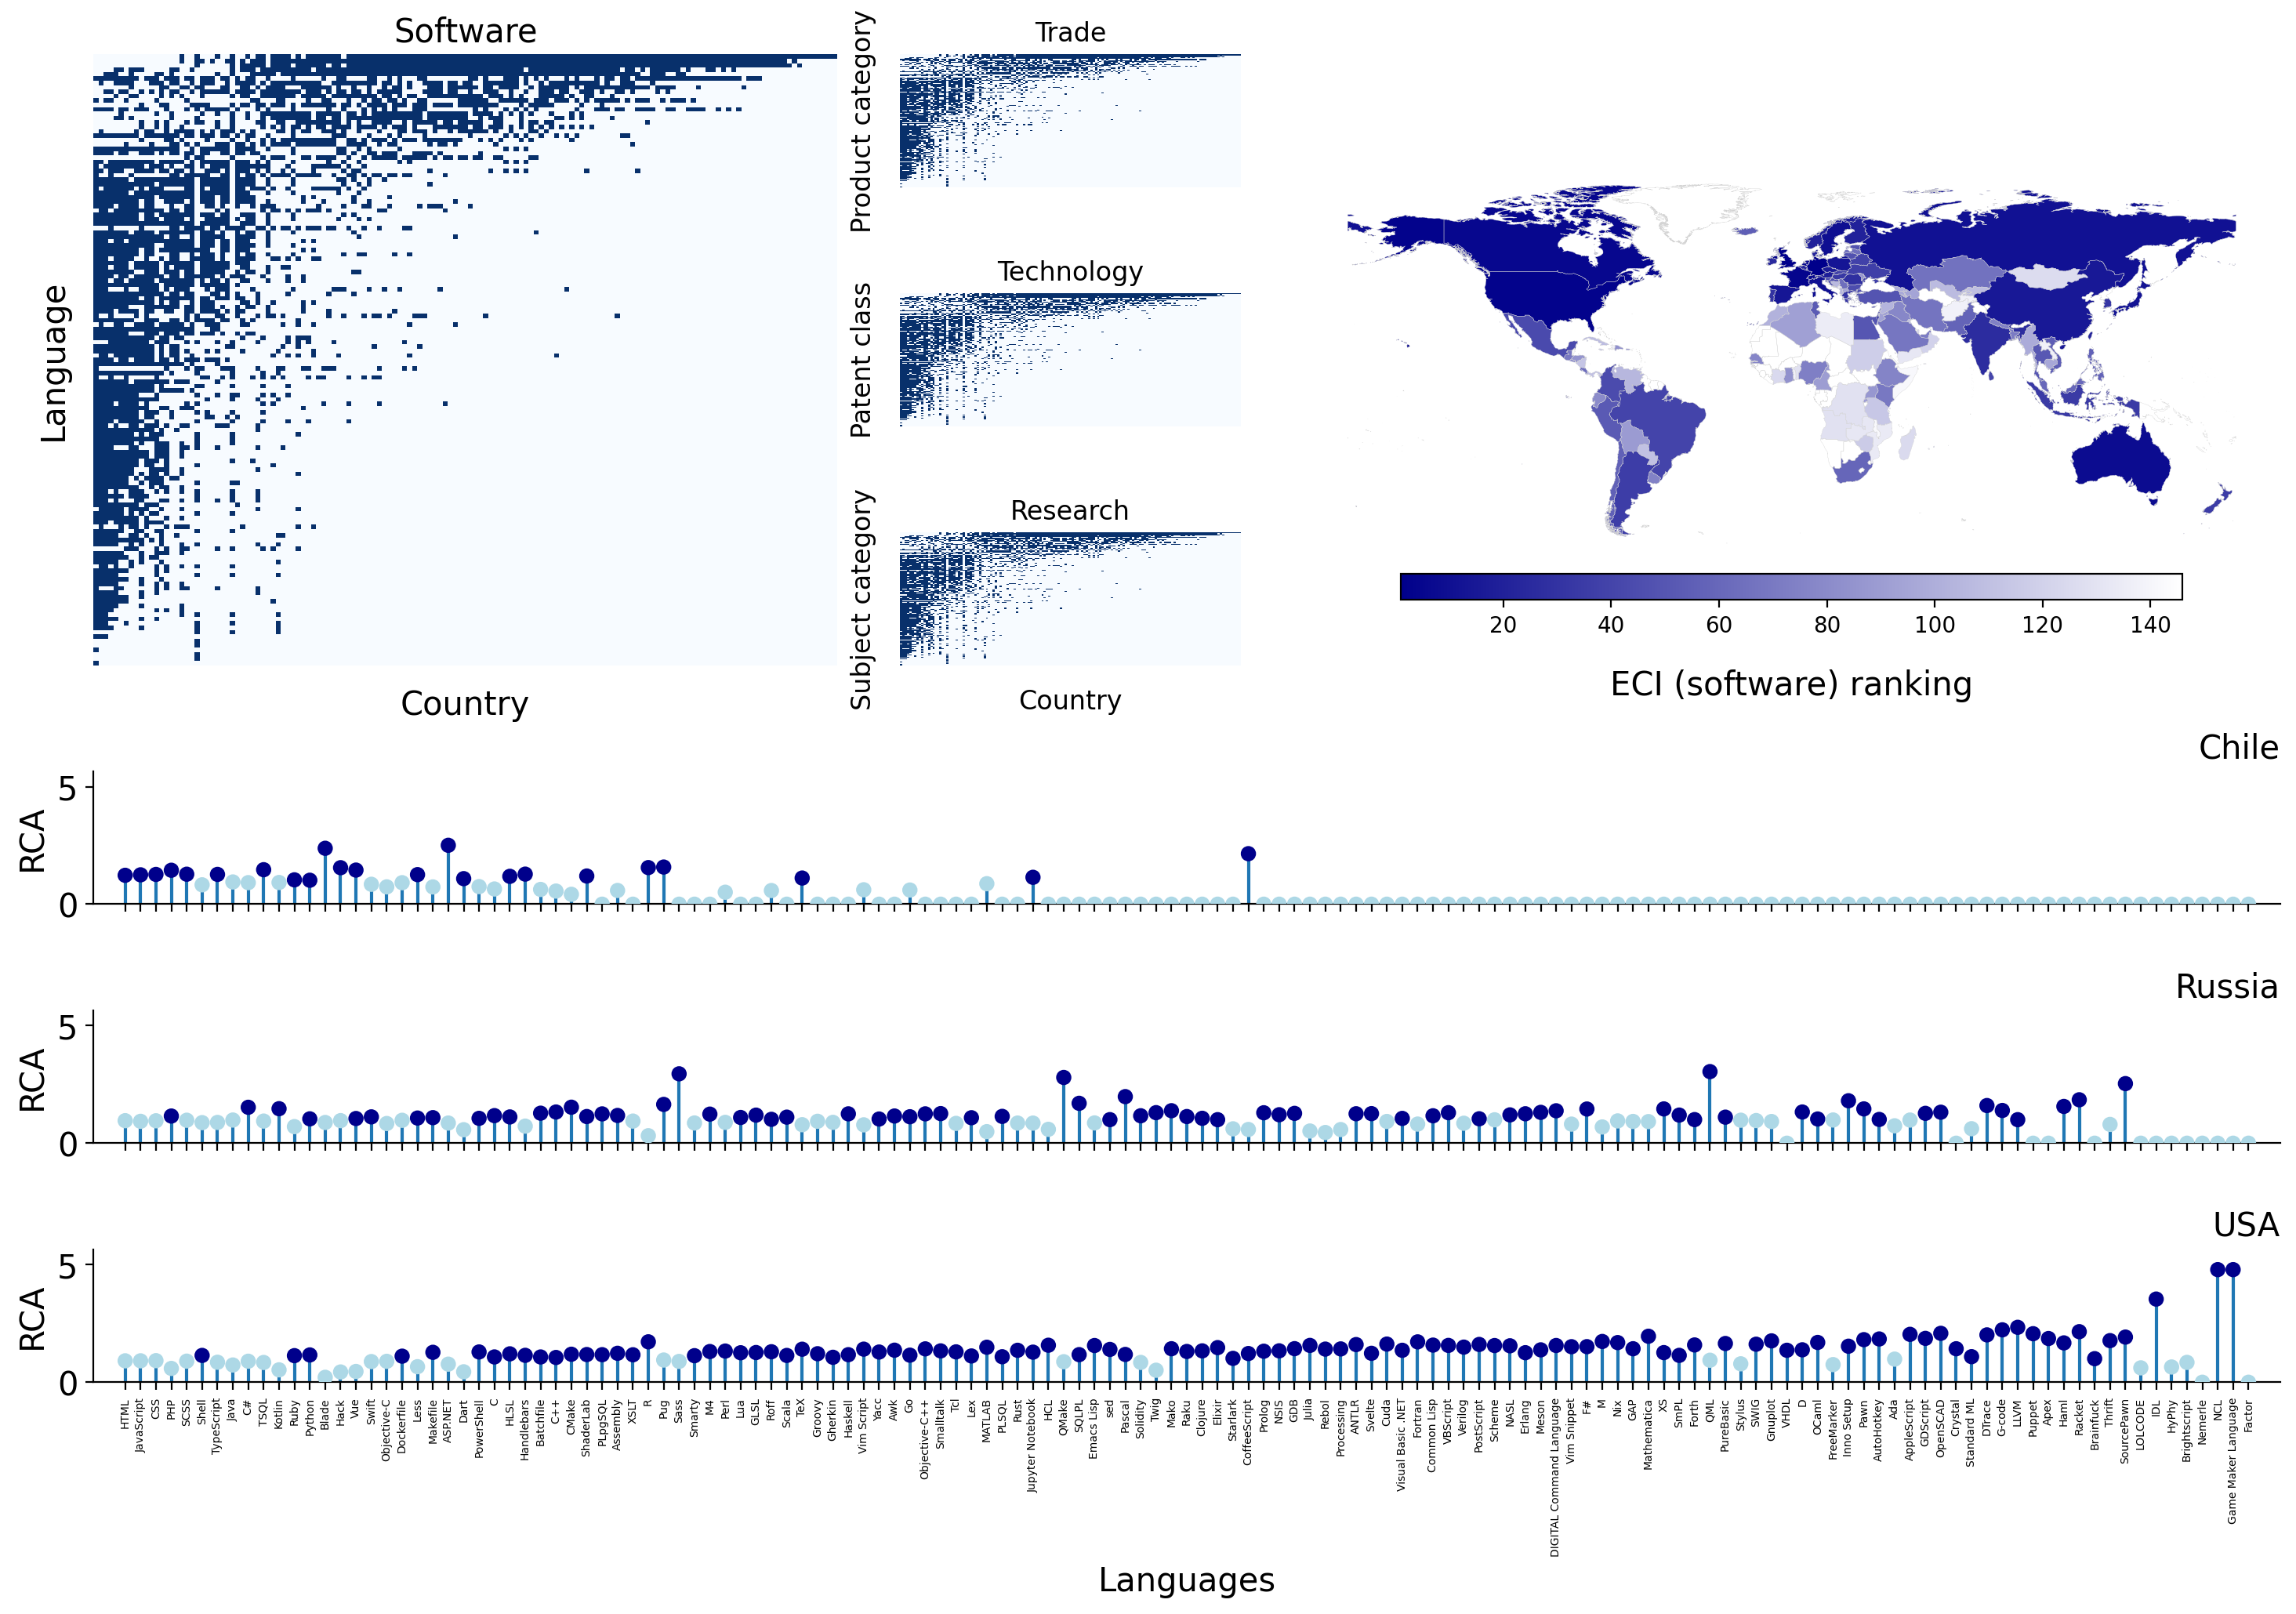

In [71]:
selected_countries = ["US", "RU", "CL"]
fig = plt.figure(figsize=(18,11))

ax = [0]*8
gs = GridSpec(6,6, figure=fig, width_ratios=[1, 1, 1, 0.5, 1, 1], hspace=0.8)
ax[0] = fig.add_subplot(gs[0:3,0:2])
ax[1] = fig.add_subplot(gs[0,2])
ax[2] = fig.add_subplot(gs[1,2])
ax[3] = fig.add_subplot(gs[2,2])
ax[4] = fig.add_subplot(gs[0:3,3:6])
ax[5] = fig.add_subplot(gs[3,0:])
ax[6] = fig.add_subplot(gs[4,0:])
ax[7] = fig.add_subplot(gs[5,0:])

#fig.subplots_adjust(hspace=1, wspace=0.25) 
fontsize = 15

# A -- M_software
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Software", "Country", "Language"], fontsize=fontsize, ax=ax[0])

# B
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Trade", "", "Product category"], fontsize=fontsize-3, ax=ax[1])

# C
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "", "Patent class"], fontsize=fontsize-3, ax=ax[2])

# D
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=fontsize-3, ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])

# F -- example country 1
lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Chile", ax=ax[5])

# G -- example country 2
lollipop_eci(cdf, selected_iso2=selected_countries[1], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Russia", ax=ax[6])

# H -- example country 3
lollipop_eci(cdf, selected_iso2=selected_countries[0], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=True, xticks=True, title_text="USA", ax=ax[7])

In [11]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

In [56]:
def eci_correlation_plot(df, key_variables, xlabel, ylabel, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.scatterplot(x=key_variables[0], y=key_variables[1], data=df, alpha=0.5, ax=ax)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[key_variables[0]], df[key_variables[1]])
    r_squared = r_value ** 2
    print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   ", key_variables[0], "  ", key_variables[1])
    ax.set_xlabel(xlabel, size=fontsize)
    ax.set_ylabel(ylabel, size=fontsize-2)
    ax.tick_params("x", labelsize=(fontsize-5))
    ax.tick_params("y", labelsize=(fontsize-5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0.015, tight=True)
    

#eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel=True, ylabel="ECI (trade)")

R2 0.596 p-value 0.0     trade_eci_2020    software_eci_2020
R2 0.606 p-value 0.0     tech_eci_2020    software_eci_2020
R2 0.519 p-value 0.0     research_eci_2020    software_eci_2020


/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_29960/1639074680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color_col"] = df["mcp"].map(color_dict)
/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_29960/1639074680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color_col"] = df["mcp"].map(color_dict)
/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_29960/1639074680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

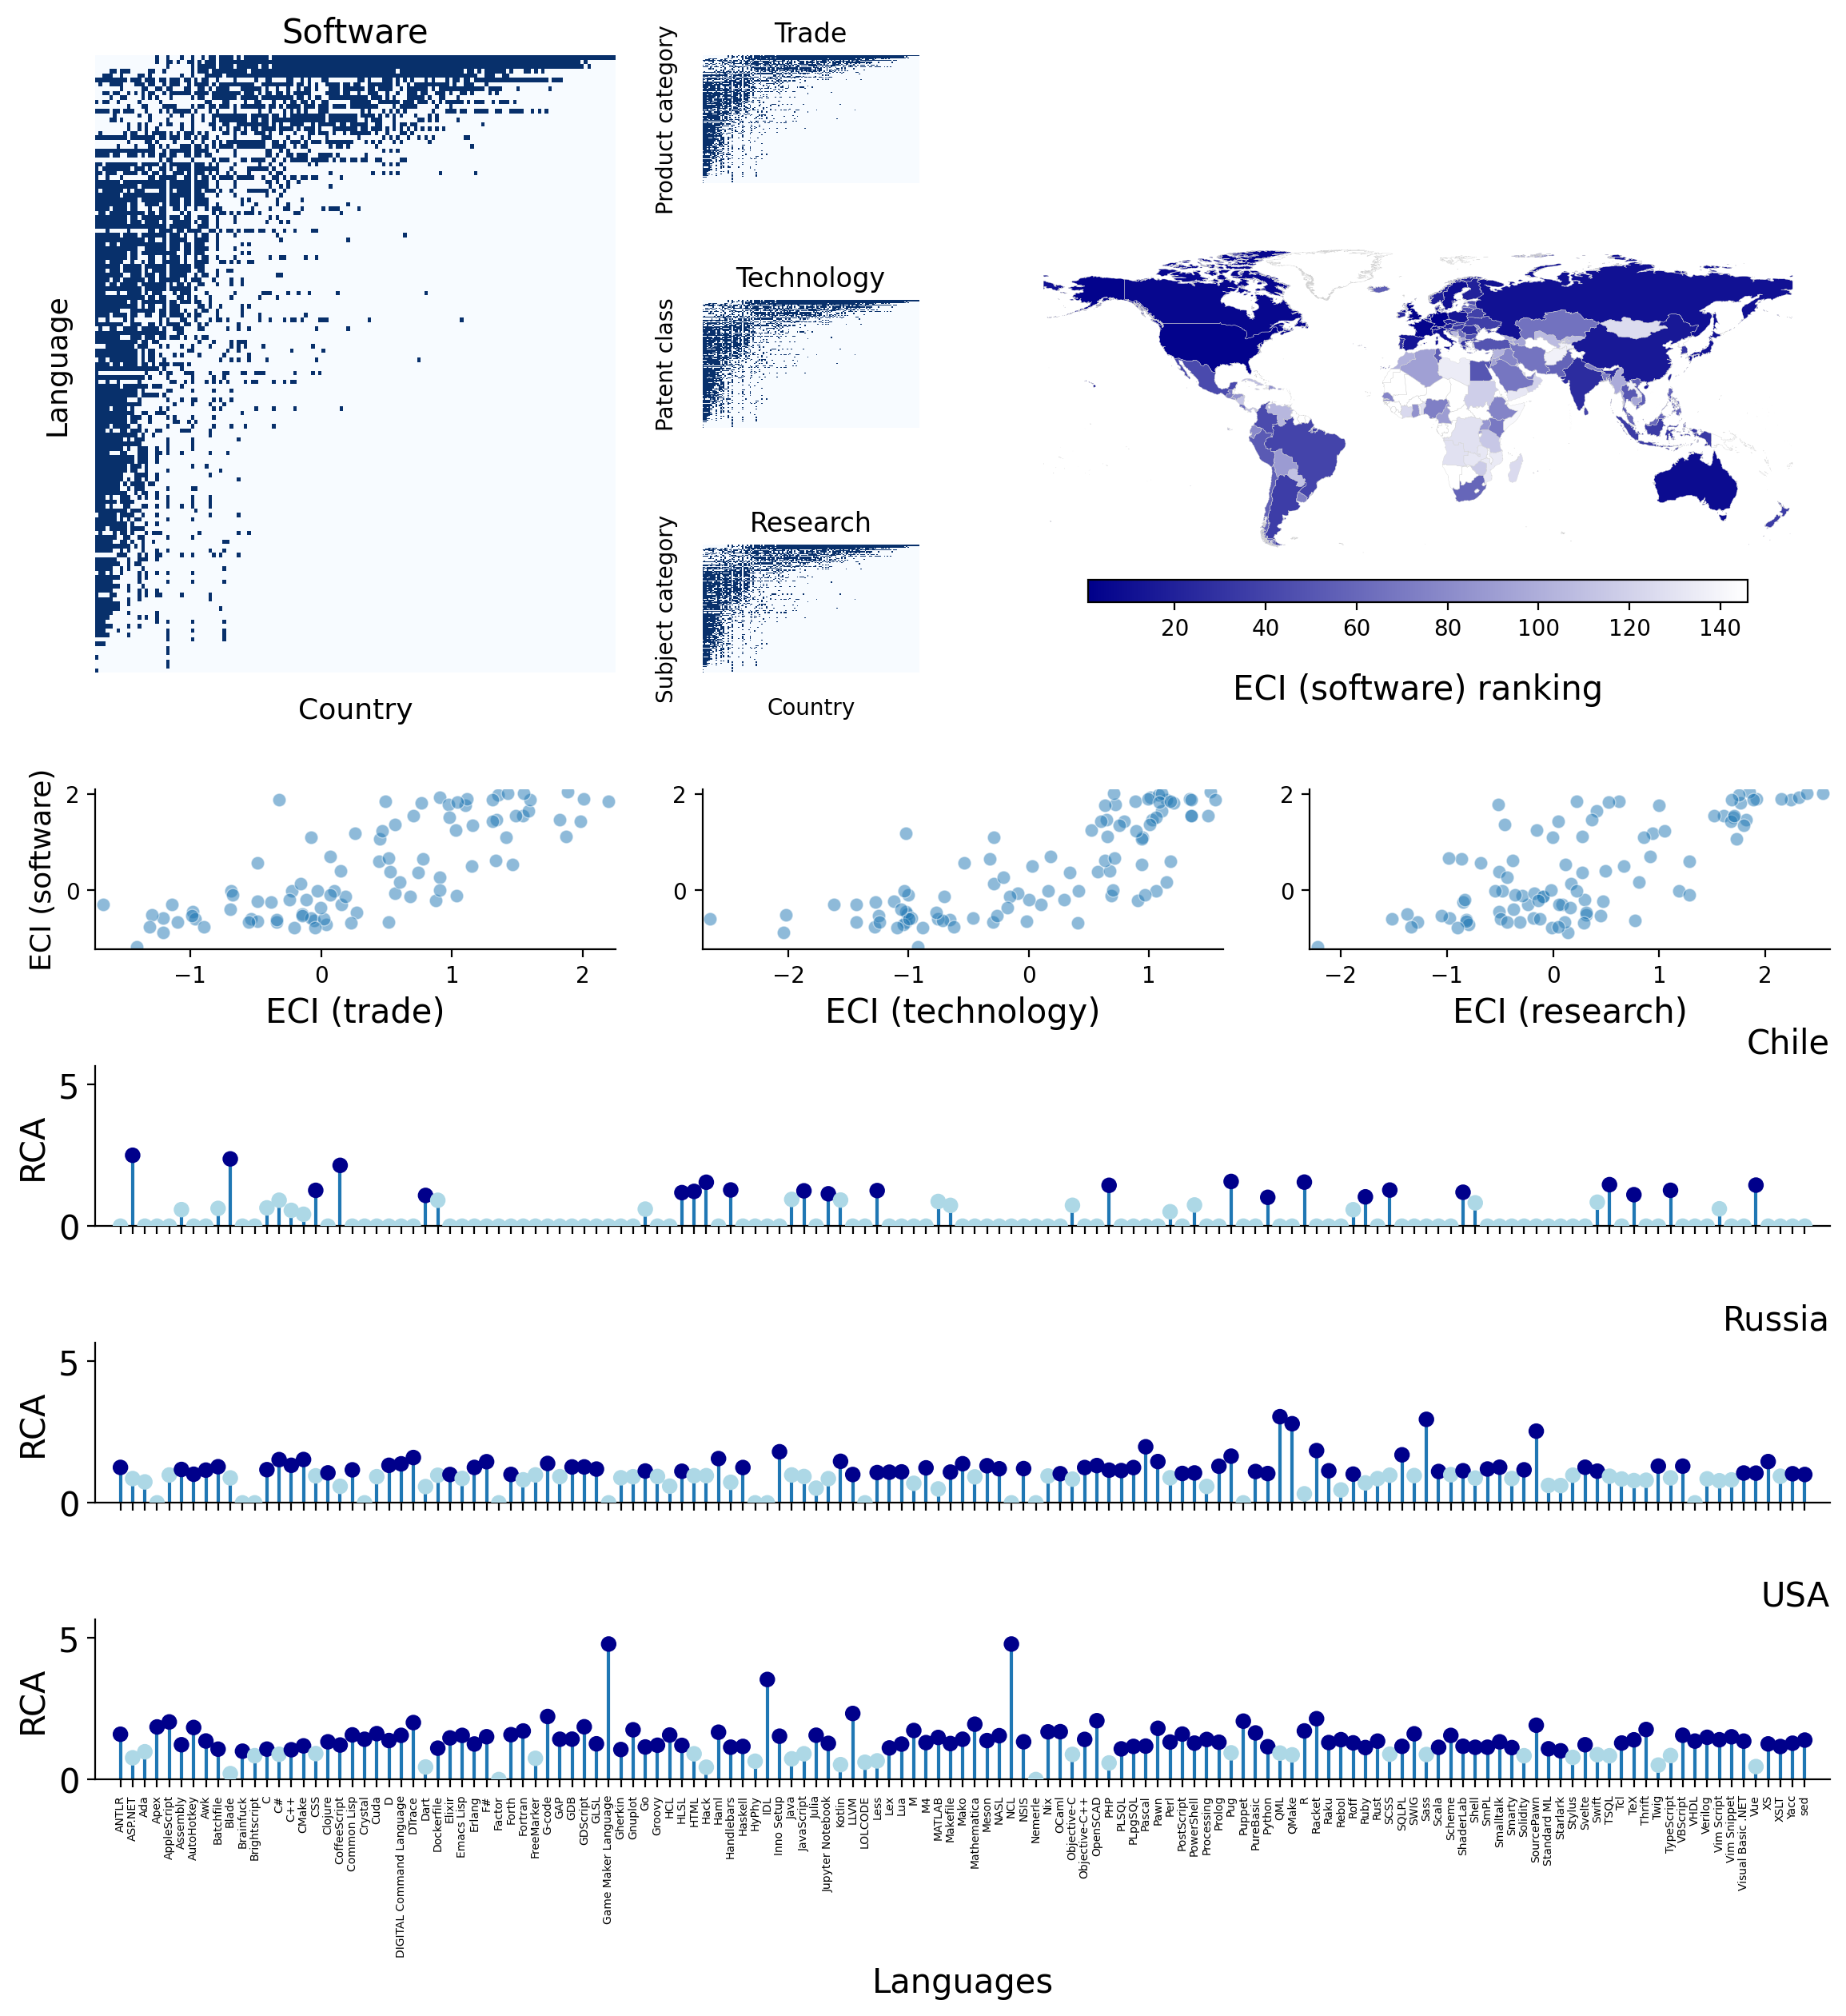

In [57]:
selected_countries = ["US", "RU", "CL"]
fontsize=15
fig = plt.figure(figsize=(14,14))

ax = [0]*11
gs = GridSpec(7,6, figure=fig, height_ratios=[0.8, 0.8, 0.8, 1, 1, 1, 1], width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.8, wspace=0.4)
ax[0] = fig.add_subplot(gs[0:3,0:2])
ax[1] = fig.add_subplot(gs[0,2])
ax[2] = fig.add_subplot(gs[1,2])
ax[3] = fig.add_subplot(gs[2,2])
ax[4] = fig.add_subplot(gs[0:3,3:6])

ax[5] = fig.add_subplot(gs[3,0:2])
ax[6] = fig.add_subplot(gs[3,2:4])
ax[7] = fig.add_subplot(gs[3,4:6])

ax[8] = fig.add_subplot(gs[4,0:])
ax[9] = fig.add_subplot(gs[5,0:])
ax[10] = fig.add_subplot(gs[6,0:])


# A -- M_software
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Software", "Country", "Language"], fontsize=fontsize, ax=ax[0])

# B
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Trade", "", "Product category"], fontsize=fontsize-3, ax=ax[1])

# C
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "", "Patent class"], fontsize=fontsize-3, ax=ax[2])

# D
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=fontsize-3, ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])

# F
eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel="ECI (trade)", ylabel="ECI (software)", ax=ax[5])

# G
eci_correlation_plot(df2, key_variables=["tech_eci_2020", "software_eci_2020"], xlabel="ECI (technology)", ylabel="", ax=ax[6])

# H
eci_correlation_plot(df2, key_variables=["research_eci_2020", "software_eci_2020"], xlabel="ECI (research)", ylabel="", ax=ax[7])

# I -- example country 1
lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Chile", ax=ax[8])

# J -- example country 2
lollipop_eci(cdf, selected_iso2=selected_countries[1], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Russia", ax=ax[9])

# K -- example country 3
lollipop_eci(cdf, selected_iso2=selected_countries[0], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=True, xticks=True, title_text="USA", ax=ax[10])

R2 0.596 p-value 0.0     trade_eci_2020    software_eci_2020
R2 0.596 p-value 0.0     tech_eci_2020    software_eci_2020
R2 0.596 p-value 0.0     research_eci_2020    software_eci_2020


/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_29960/1639074680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color_col"] = df["mcp"].map(color_dict)
/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_29960/1639074680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color_col"] = df["mcp"].map(color_dict)
/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_29960/1639074680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

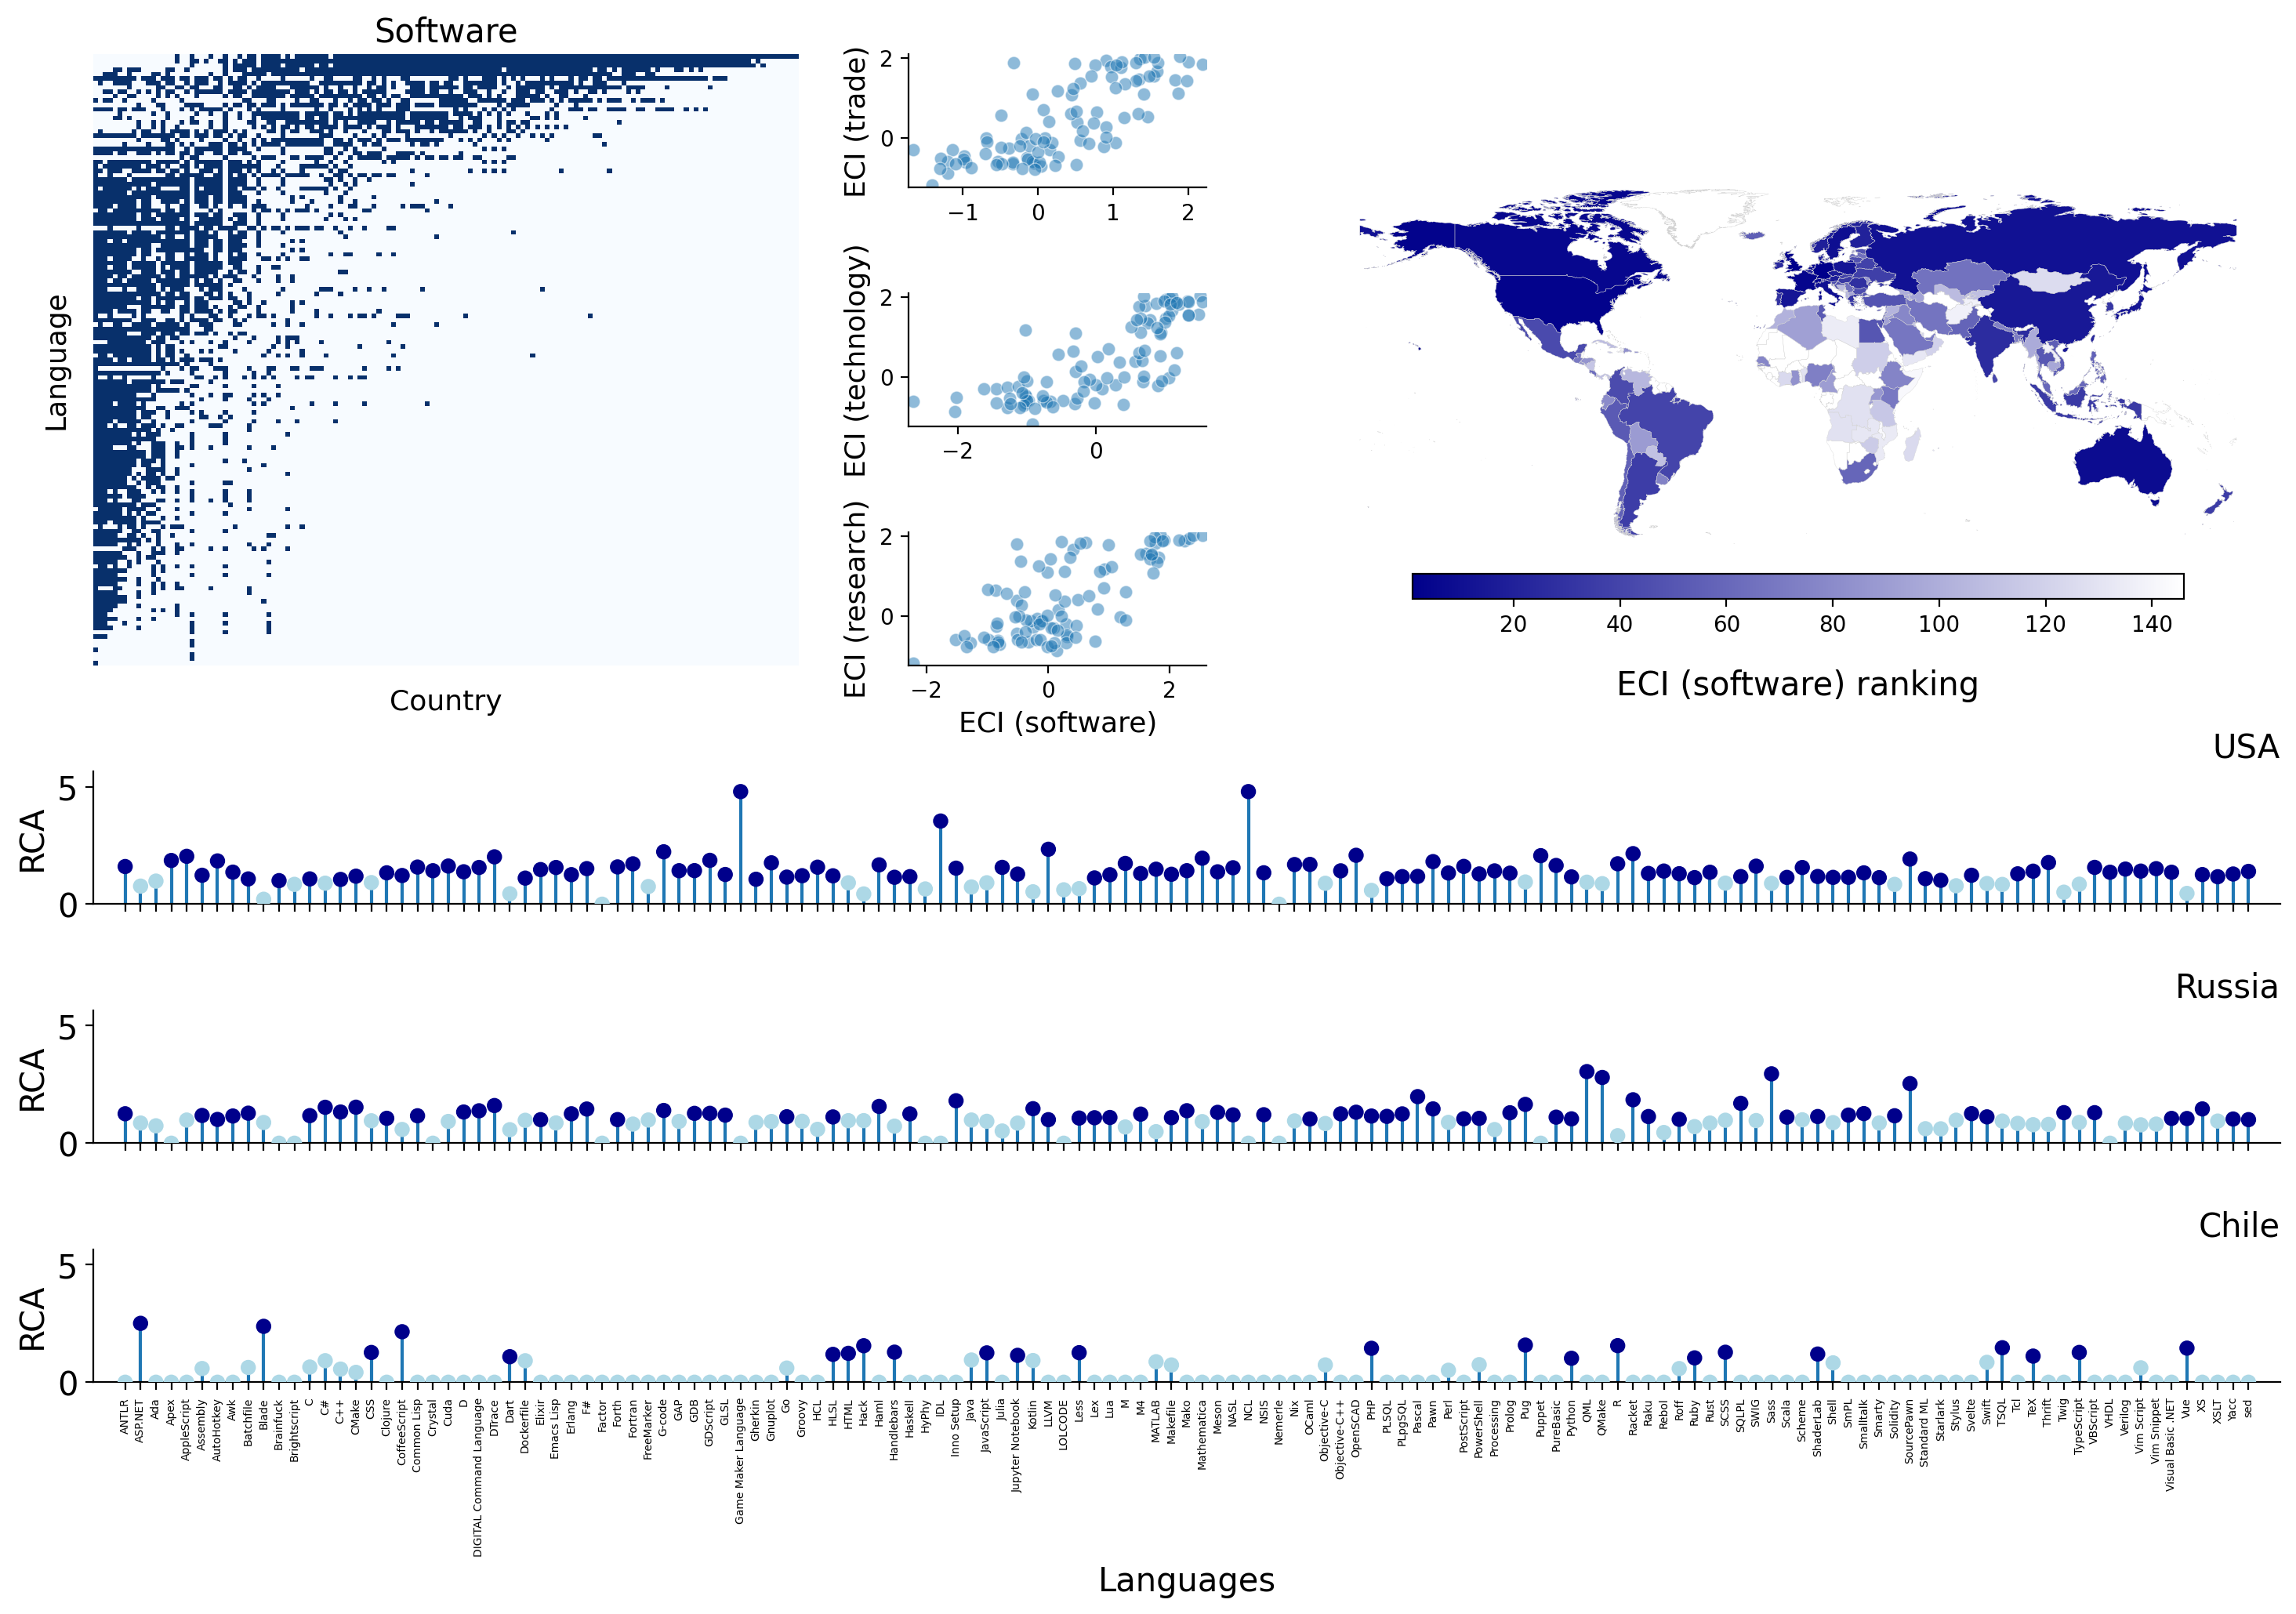

In [26]:
selected_countries = ["US", "RU", "CL"]
fig = plt.figure(figsize=(18,11))

ax = [0]*8
gs = GridSpec(6,6, figure=fig, width_ratios=[1, 1, 1, 0.5, 1, 1], hspace=0.8, wspace=0.4)
ax[0] = fig.add_subplot(gs[0:3,0:2])
ax[1] = fig.add_subplot(gs[0,2])
ax[2] = fig.add_subplot(gs[1,2])
ax[3] = fig.add_subplot(gs[2,2])
ax[4] = fig.add_subplot(gs[0:3,3:6])
ax[5] = fig.add_subplot(gs[3,0:])
ax[6] = fig.add_subplot(gs[4,0:])
ax[7] = fig.add_subplot(gs[5,0:])

#fig.subplots_adjust(hspace=1, wspace=0.25) 
fontsize = 15

# A -- M_software
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Software", "Country", "Language"], fontsize=fontsize, ax=ax[0])

# B
eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel=False, ylabel="ECI (trade)", ax=ax[1])

# C
eci_correlation_plot(df2, key_variables=["tech_eci_2020", "software_eci_2020"], ylabel="ECI (technology)", xlabel=False, ax=ax[2])

# D
eci_correlation_plot(df2, key_variables=["research_eci_2020", "software_eci_2020"], xlabel=True, ylabel="ECI (research)", ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])

# F -- example country 1
lollipop_eci(cdf, selected_iso2=selected_countries[0], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="USA", ax=ax[5])

# G -- example country 2
lollipop_eci(cdf, selected_iso2=selected_countries[1], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Russia", ax=ax[6])

# H -- example country 3
lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=True, xticks=True, title_text="Chile", ax=ax[7])

In [76]:
# ranking
def ranking_barplot(df, ax=None):
    if ax is None:
        ax = plt.gca()
    

**Figure 1 -- ECI(software, trade, technology, research) comparison**

In [2]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

R2 0.606 p-value 0.0    software - trade
R2 0.617 p-value 0.0    software - technology
R2 0.517 p-value 0.0    software - research


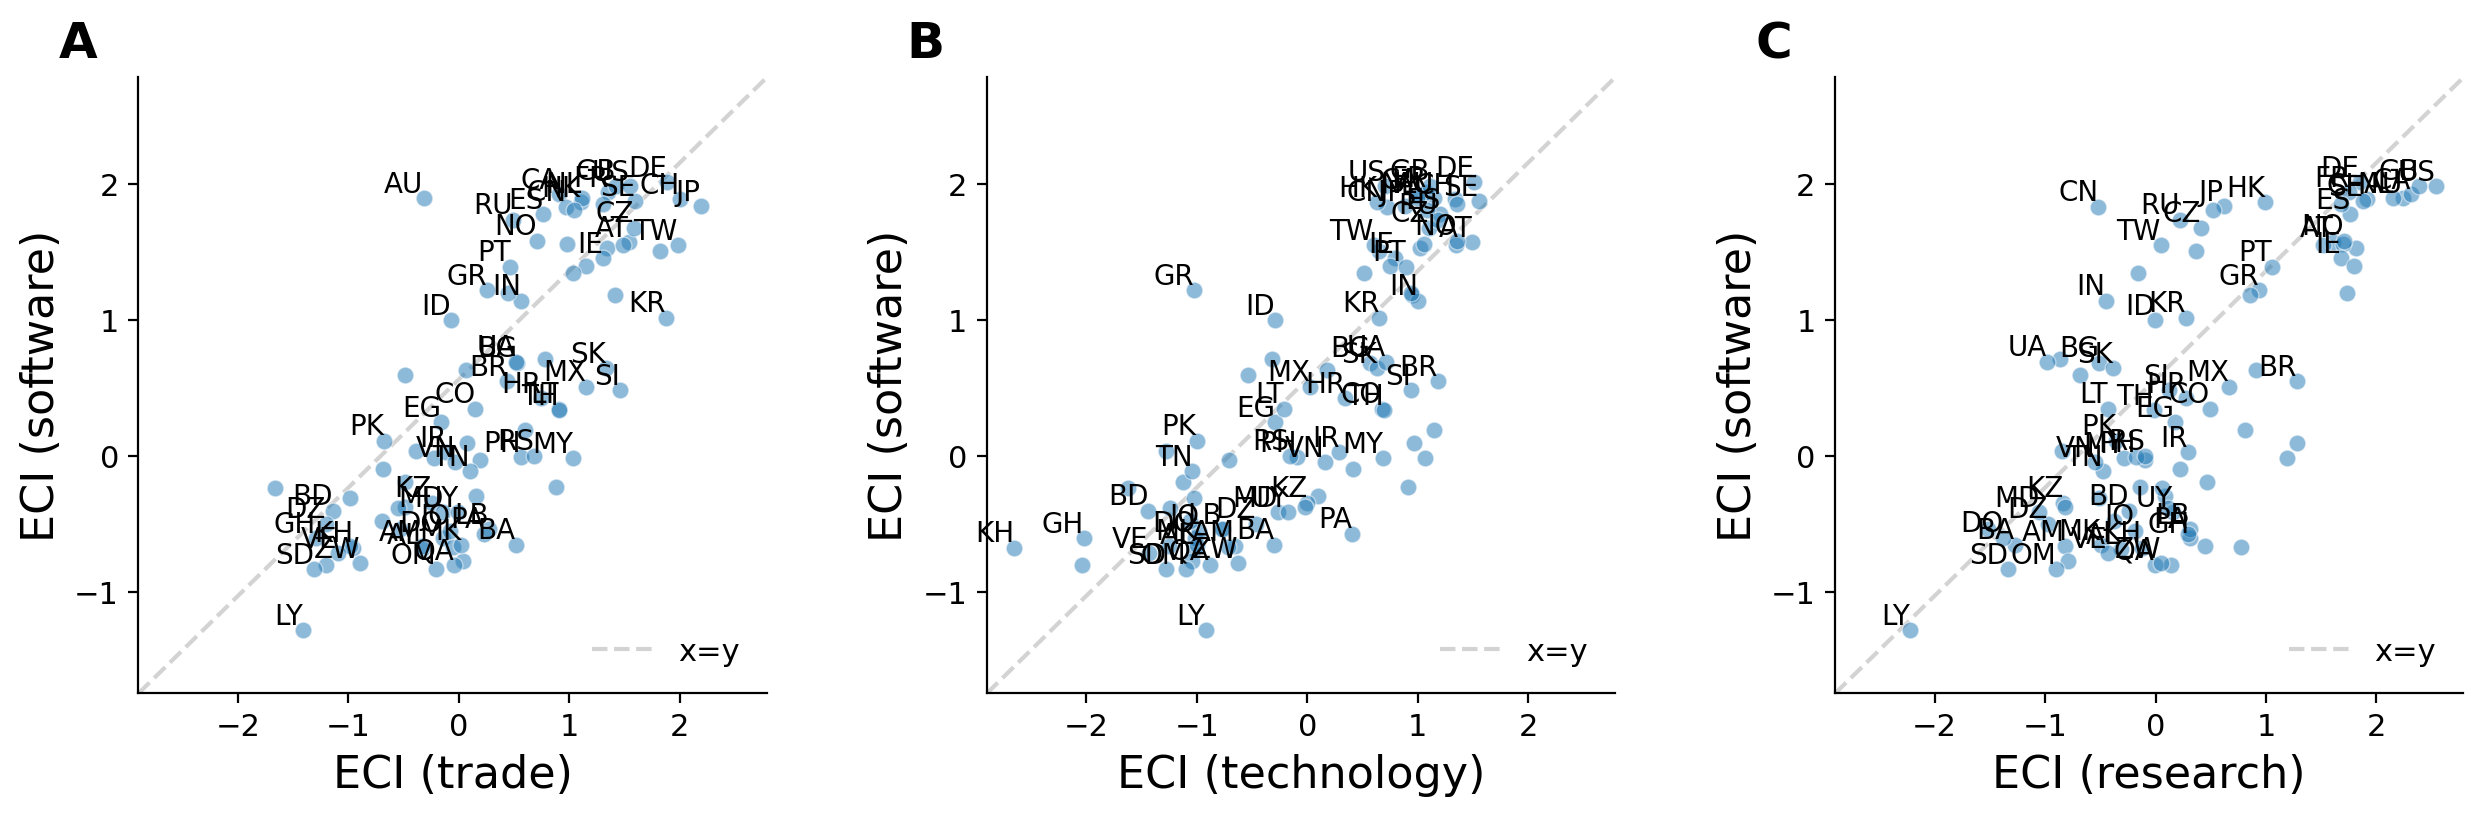

In [3]:
# ECI comparison
fig, ax = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.35)
fontsize = 16


# for axis setting
min_value = df2[["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].min().min() - 0.25
max_value = df2[["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].max().max() + 0.25


# A -- software vs trade
sns.scatterplot(x="trade_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[0])
#sns.regplot(x="trade_eci_2020", y="seci_2020", data=df2, scatter=False, ci=95, ax=ax[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2['trade_eci_2020'], df2['software_eci_2020'])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - trade")
#ax[0].annotate(f'R2: {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
ax[0].set_xlabel("ECI (trade)", size=fontsize)
ax[0].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[0].text(
            df2["trade_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 != 0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# B -- software vs technology
sns.scatterplot(x="tech_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[1])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2["tech_eci_2020"], df2["software_eci_2020"])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - technology")
ax[1].set_xlabel("ECI (technology)", size=fontsize)
ax[1].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[1].text(
            df2["tech_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 != 0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# C -- software vs research
sns.scatterplot(x="research_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[2])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2["research_eci_2020"], df2["software_eci_2020"])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - research")
ax[2].set_xlabel("ECI (research)", size=fontsize)
ax[2].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[2].text(
            df2["research_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 !=  0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# common axis settings
for p in [0,1,2]:
    ax[p].tick_params("x", labelsize=(fontsize-5))
    ax[p].tick_params("y", labelsize=(fontsize-5))
    ax[p].spines['top'].set_visible(False)
    ax[p].spines['right'].set_visible(False)
    ax[p].set_xlim(min_value, max_value)
    ax[p].set_ylim(-1.75, max_value)
    ax[p].plot(ax[p].get_xlim(), ax[p].get_ylim(), ls="--", c="lightgrey", label="x=y", zorder=0)
    ax[p].legend(loc="lower right", frameon=False, prop={'size': fontsize-5},)


# subplot title
for a, label in zip(ax, ['A','B','C','D']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,20), textcoords='offset pixels', weight='bold', size=fontsize+2)


# save
plt.savefig(f"../figures/fig01_eci_comparison.png", dpi=300, bbox_inches="tight", facecolor="white")

**Figure 2 -- language space**

In [4]:
# language space from code/01_data_prep_complexity.ipynb
el = pd.read_csv("../outputs/software_space_edgelist_2020_2021_based.csv", sep=";")
cdf = pd.read_csv("../outputs/software_complexity_2020_2021_based.csv", sep=";")

In [5]:
posh_list = [
    "Stata",
    "Julia",
    #"Mathematica",
    "GAP",
    "Elm",
    "OCaml",
    "VBA",
    "Fortran",
    "Cuda",
    "Pascal",
    "sed",
    "Perl",
    "awk",
    #"MATLAB",
    "R",
    "C",
    "C++",
    "Python",
    "Java",
    "Typescript",
    "HTML",
    #"CSS",
    "C#",
    "Swift",
    "Kotlin",
    "UnrealScript",
    "Lisp",
    "LLVM",
    #"Brainfuck",
    "CoffeeScript",
    "Prolog",
    #"F#",
    "Scheme",
    #"PowerShell",
    "Jupyter Notebook",
    "Racket",
    #"Game Maker Language",
    "HyPhy",
    "OpenSCAD",
    "Bicep"
]

In [6]:
def software_space_of_country(el, complexity_table, country_code):
    # focal country
    ctable = complexity_table[complexity_table["iso2_code"]==country_code]
    
    # RCA filter
    ctable = ctable[ctable["rca"] >= 1]

    cel = pd.merge(
        el,
        ctable[["language", "rca"]].drop_duplicates(),
        left_on="language_1",
        right_on="language",
        how="left"
    )
    cel = pd.merge(
        cel,
        ctable[["language", "rca"]].drop_duplicates(),
        left_on="language_2",
        right_on="language",
        how="left",
        suffixes=["_i", "_j"]
    )

    # filter cel
    cel = cel.dropna(subset=["rca_i", "rca_j"])
    
    # clean up
    cel = cel[["language_1", "language_2", "proximity"]]

    return cel

In [15]:
# common setting
selected_seed=15

def custom_graphviz_layout(G, seed=None, **kwargs):
    """graphviz layout does not have a built in seed otion"""
    # set the random seed if provided
    if seed is not None:
        random.seed(seed)
    # call the original graphviz_layout function with any additional kwargs
    return nx.drawing.nx_agraph.graphviz_layout(G, **kwargs)

#pos = nx.drawing.nx_agraph.graphviz_layout(ss_graph, prog='neato')
ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")
pos = custom_graphviz_layout(ss_graph, seed=selected_seed, prog='neato')

#pos = {key: (value[0]*0.85, value[1]) for key, value in pos.items()}

In [16]:
el1 = software_space_of_country(el, cdf, country_code="IN")
graph1 = nx.from_pandas_edgelist(el1, source="language_1", target="language_2")
el2 = software_space_of_country(el, cdf, country_code="US")
graph2 = nx.from_pandas_edgelist(el2, source="language_1", target="language_2")
el3 = software_space_of_country(el, cdf, country_code="RU")
graph3 = nx.from_pandas_edgelist(el3, source="language_1", target="language_2")

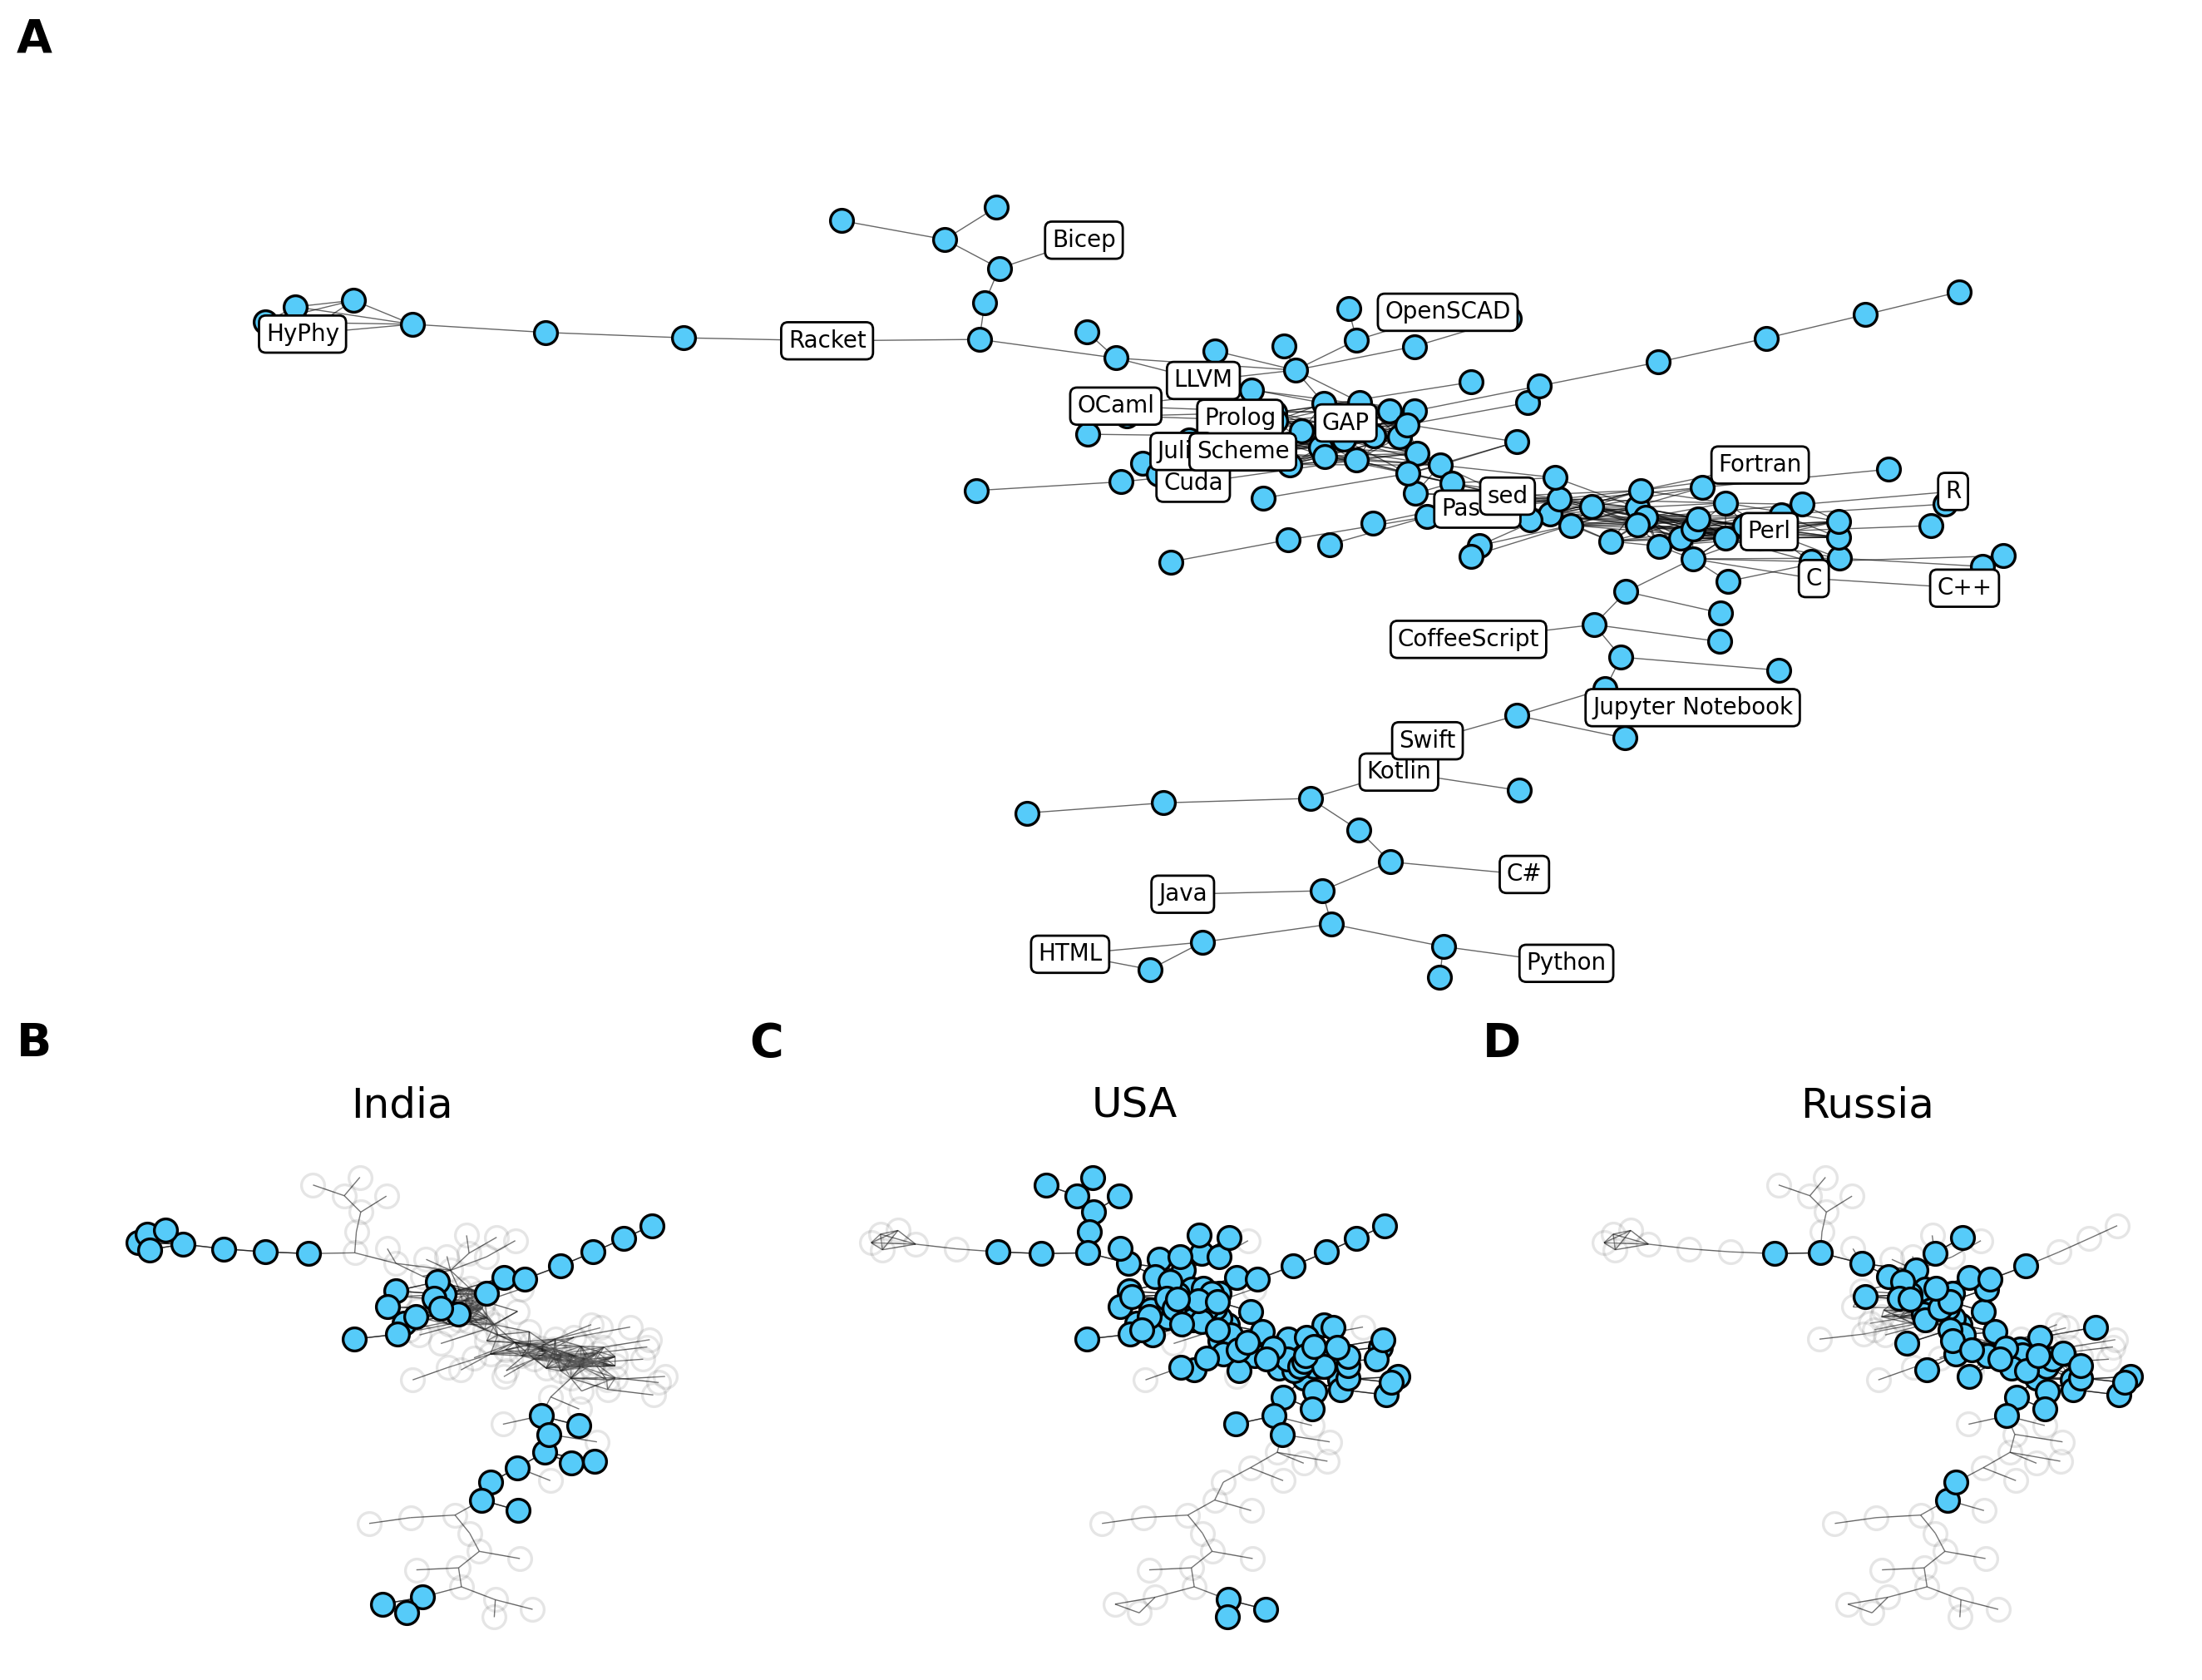

In [17]:
fig = plt.figure(figsize=(22,12))

ax = [0]*8
gs = GridSpec(2,4, figure=fig, height_ratios=[1.75, 1])
ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[1,0])
ax[2] = fig.add_subplot(gs[1,1])
ax[3] = fig.add_subplot(gs[1,2])
fig.subplots_adjust(hspace=0.1, wspace=0.15)

fontsize = 18

# A -- full graph
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color="black", width=.5, alpha=.6, ax=ax[0])
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color="#56CBF9", linewidths=1.2, edgecolors='black', ax=ax[0])
nx.draw_networkx_labels(ss_graph.subgraph(posh_list), bbox = dict(facecolor = "white", boxstyle="round"), pos=pos, font_size=fontsize-8, ax=ax[0])
ax[0].axis('off')

# B -- graph1
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[1])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_edges(graph1, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
#nx.draw_networkx_nodes(hu_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[1])
nx.draw_networkx_nodes(graph1, pos, node_size=100, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax[1]) # alpha=.5
ax[1].axis('off')
ax[1].set_title("India", size=fontsize)

# C -- Sweden
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[2])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_edges(graph2, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
#nx.draw_networkx_nodes(se_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[2])
nx.draw_networkx_nodes(graph2, pos, node_size=100, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax[2]) # alpha=.5
ax[2].axis('off')
ax[2].set_title("USA", size=fontsize)

# D -- Serbia
nx.draw_networkx_nodes(ss_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[3])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_edges(graph3, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
#nx.draw_networkx_nodes(rs_graph, pos, node_size=100, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[3])
nx.draw_networkx_nodes(graph3, pos, node_size=100, node_color='#56CBF9', linewidths=1.2, edgecolors='black', ax=ax[3]) # alpha=.5
ax[3].axis('off')
ax[3].set_title("Russia", size=fontsize)

# subplot title
for a, label in zip(ax, ['A','B','C','D']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,90), textcoords='offset pixels', weight='bold', size=fontsize+2)

# save
#plt.savefig(f"../figures/fig02_language_spaces.png", dpi=300, bbox_inches="tight", facecolor="white")

In [18]:
print(ss_graph.number_of_nodes(), " nodes")
print(ss_graph.number_of_edges(), " edges")

148  nodes
443  edges


(-51.39593, 1173.9299299999998, -189.375, 2200.375)

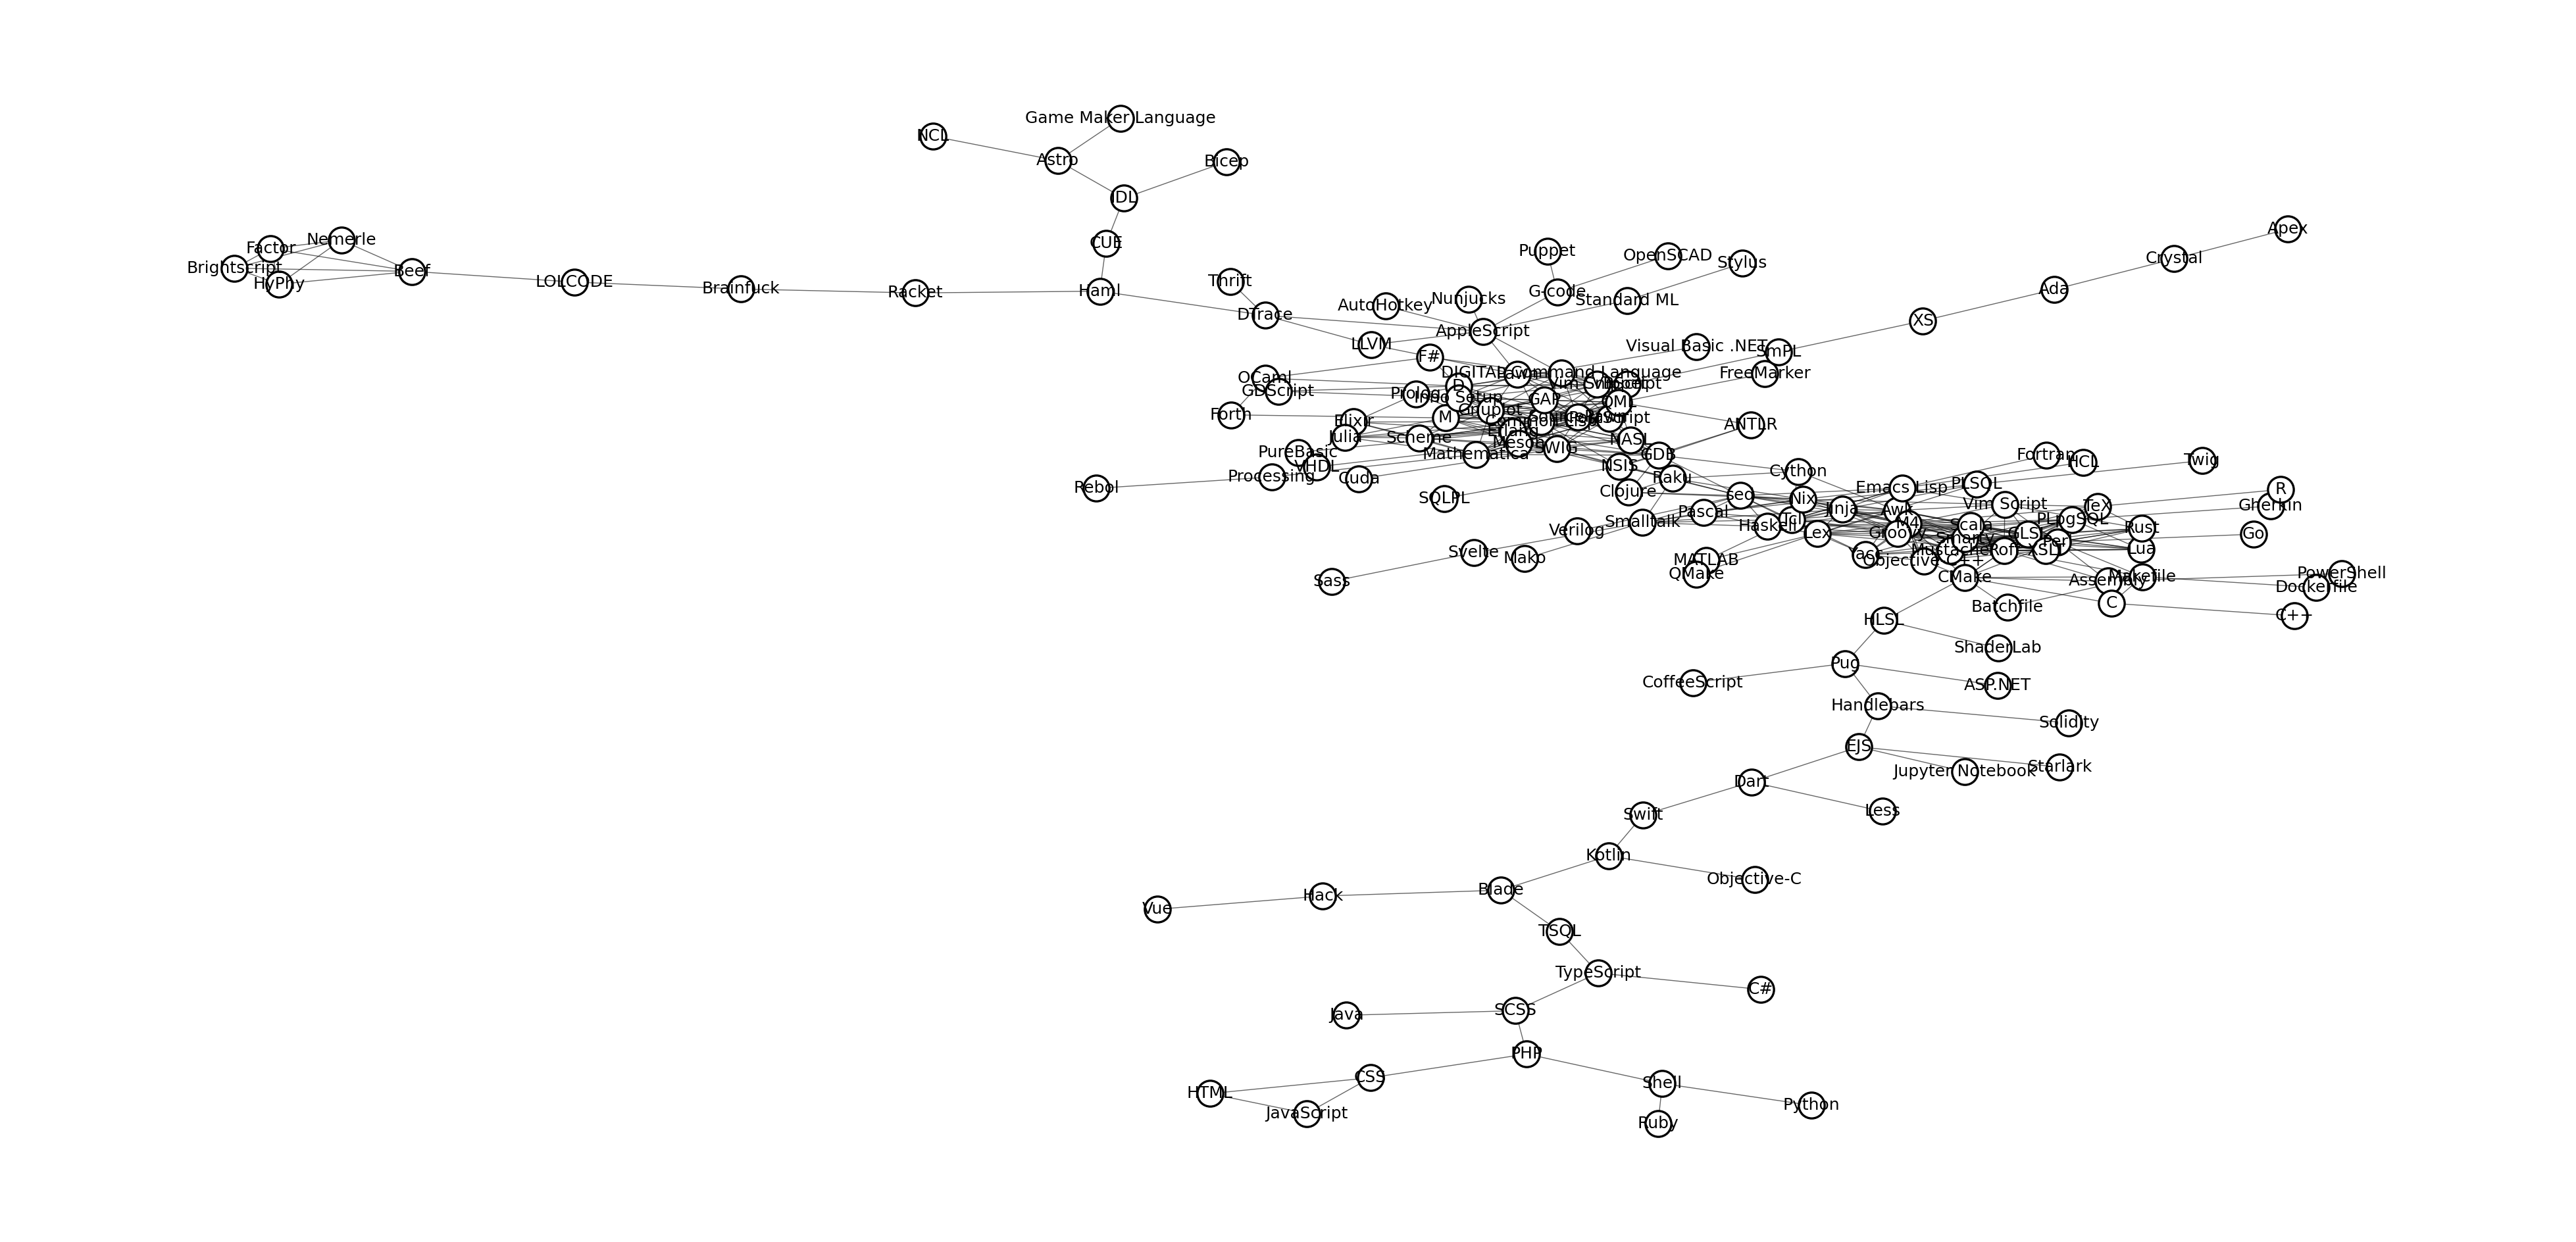

In [19]:
# full network plot
ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(25,12))
pos = nx.drawing.nx_agraph.graphviz_layout(ss_graph, prog='neato')

nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax)
#nx.draw_networkx_nodes(ss_graph, pos, node_size=250, node_color='white',linewidths=1.2, edgecolors='black', ax=ax) # alpha=.1,
nx.draw_networkx_nodes(ss_graph, pos, node_size=200, node_color='white',
#'#56CBF9',
linewidths=1.2, edgecolors='black', ax=ax) # alpha=.5,

nx.draw_networkx_labels(ss_graph,# bbox = dict(facecolor = "white",boxstyle='round'),
    pos=pos,font_size=9, ax=ax)
ax.axis('off')

In [20]:
cdf[["language", "pci"]].drop_duplicates().sort_values(by="pci").head(20)

language       pci
53          HTML -1.325583
19           CSS -1.315457
62    JavaScript -1.213575
30          Dart -0.796010
90           PHP -0.758971
111         Ruby -0.752672
113         SCSS -0.727800
61          Java -0.608266
54          Hack -0.597794
130        Swift -0.578998
143          Vue -0.571271
12         Blade -0.565568
66        Kotlin -0.486592
87   Objective-C -0.345889
120        Shell -0.318864
69          Less -0.285875
131         TSQL -0.272061
136   TypeScript -0.241252
103       Python -0.078942
16            C#  0.026118